In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
from torchinfo import summary

from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\andresespinalh\AppData\Local\Temp\ipykernel_25192\3761831838.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


### Exploratory Data Analysis

In [2]:
df_songs = pd.read_csv(r'../data/data.csv')
labels_dict = {
    0: 'Rock', 
    1: 'Indie', 
    2: 'Alt', 
    3: 'Pop', 
    4: 'Metal', 
    5: 'HipHop', 
    6: 'Alt_Music', 
    7: 'Blues', 
    8: 'Acoustic/Folk', 
    9: 'Instrumental', 
    10: 'Country', 
    11: 'Bollywood'
}
# profile = ProfileReport(df_songs, title="Pandas Profiling Report")
# profile.to_widgets()

### Data Pre-Processing

In [3]:
# Drop useless columns (High Cardinality)
df_songs = df_songs.drop(['Artist Name', 'Track Name'], axis=1)

# Fill empty values in 'popularity' with the mean
df_songs['Popularity'] = df_songs['Popularity'].fillna(df_songs['Popularity'].mean())
df_songs['key'] = df_songs['key'].fillna(df_songs['key'].mode()[0])
df_songs['instrumentalness'] = df_songs['instrumentalness'].fillna(df_songs['instrumentalness'].mean())

# Normalization
df_norm = df_songs[['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms']]
mean_norm = df_norm.mean()
std_norm = df_norm.std()
df_norm = (df_norm-mean_norm) / std_norm

# Categorical Features
df_categorical = df_songs[['key', 'mode', 'time_signature', 'Class']]

# Put everything together
df_preprocessed = df_norm.merge(df_categorical, how='inner', left_index=True, right_index=True)

### Train/Test Splitting

In [4]:
X = df_preprocessed.drop('Class', axis=1)
y = df_preprocessed['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('Training Set: {0}, Test Set: {1}'.format(len(X_train), len(y_test)))

Training Set: 13497, Test Set: 4499


### Artificial Neural Network Modelling

In [5]:
# Connect to the GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Create PyTorch Tensors
inputs = torch.tensor(X_train.values).float()
outputs = torch.tensor(y_train.values)

print('Inputs: {0}, Outputs: {1}'.format(X_train.shape[1], len(y_train.unique())))

Inputs: 14, Outputs: 11


In [6]:
# # Model Architecture
# ann_genres = nn.Sequential(
#     nn.Linear(14, 256), # Input Layer
#     nn.ReLU(), # Activation Function
#     nn.Linear(256, 256), # Hidden Layer
#     nn.ReLU(), # Activation Function
#     nn.Linear(256, 256), # Hidden Layer
#     nn.ReLU(), # Activation Function
#     nn.Linear(256, 256), # Hidden Layer
#     nn.ReLU(), # Activation Function
#     nn.Linear(256, 256), # Hidden Layer
#     nn.ReLU(), # Activation Function
#     nn.Linear(256, 11) # Output Layer
# )

# # Loss Function
# loss_function = nn.CrossEntropyLoss()

# # Optimizer
# optimizer = torch.optim.SGD(ann_genres.parameters(), lr=0.1)

In [7]:
# ANN Architecture
class ANNGenres(nn.Module):
    def __init__(self, n_layers, n_units):
        super().__init__()

        # Set Attributes
        self.n_layers = n_layers
        self.n_units = n_units

        # Dictionary to store the layers
        self.layers = nn.ModuleDict()

        # Input Layer
        self.layers['input'] = nn.Linear(14, n_units)

        # Hidden Layers
        for i in range(n_layers):
            self.layers[f'hidden_{i}'] = nn.Linear(n_units, n_units)

        # Output Layer
        self.layers['output'] = nn.Linear(n_units, 11)

    def forward(self, x):
        # Input Layer
        x = F.relu(self.layers['input'](x))

        # Hidden Layers
        for i in range(self.n_layers):
            x = F.relu(self.layers[f'hidden_{i}'](x))

        # Output Layer
        x = self.layers['output'](x)

        return x

In [8]:
ann_genres = ANNGenres(4, 256)
summary(ann_genres, input_data=inputs, device='cuda:0')

c:\Users\andresespinalh\miniconda3\envs\py-dudlcourse\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\andresespinalh\miniconda3\envs\py-dudlcourse\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ANNGenres                                [13497, 11]               --
├─ModuleDict: 1-1                        --                        --
│    └─Linear: 2-1                       [13497, 256]              3,840
│    └─Linear: 2-2                       [13497, 256]              65,792
│    └─Linear: 2-3                       [13497, 256]              65,792
│    └─Linear: 2-4                       [13497, 256]              65,792
│    └─Linear: 2-5                       [13497, 256]              65,792
│    └─Linear: 2-6                       [13497, 11]               2,827
Total params: 269,835
Trainable params: 269,835
Non-trainable params: 0
Total mult-adds (G): 3.64
Input size (MB): 0.76
Forward/backward pass size (MB): 139.40
Params size (MB): 1.08
Estimated Total Size (MB): 141.23

### Training

In [9]:
def train_model(model, inputs, outputs, n_epochs, learning_rate):
    # Send to device
    model.to(device)
    inputs = inputs.to(device)
    outputs = outputs.to(device)
    
    # Loss Function
    loss_function = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Initialize the Losses
    losses = torch.zeros(n_epochs)
    epoch_accuracy = []
    predicted_classes_dict = {}
    matches_dict = {}

    # For each Epoch
    for epoch_i in range(n_epochs):
        # Forward Pass
        y_hat = model(inputs)

        # Compute the Loss
        loss = loss_function(y_hat, outputs)
        losses[epoch_i] = loss.cpu()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute Accuracy
        predicted_classes = torch.argmax(y_hat, axis=1)
        matches = (predicted_classes == outputs).float()
        accuracy_pct = 100 * torch.mean(matches)
        epoch_accuracy.append(accuracy_pct.cpu())
        matches_dict[epoch_i] = matches.cpu()

    # Final Forward Pass
    predictions = ann_genres(inputs)

    pred_labels =  torch.argmax(predictions, axis=1)
    final_accuracy = 100*torch.mean((pred_labels == outputs).float())

    result = {'loss': losses.detach(), 'accuracy': epoch_accuracy, 'final_accuracy': final_accuracy.cpu(), 'matches': matches_dict}

    return result

In [10]:
n_epochs = 1000
result = train_model(ann_genres, inputs, outputs, n_epochs, 0.1)
final_accuracy = result['final_accuracy'].numpy()
final_loss = result['loss'][len(result['loss'])-1]

Final Model Accuracy: 50.211
Final Model Loss: 1.287


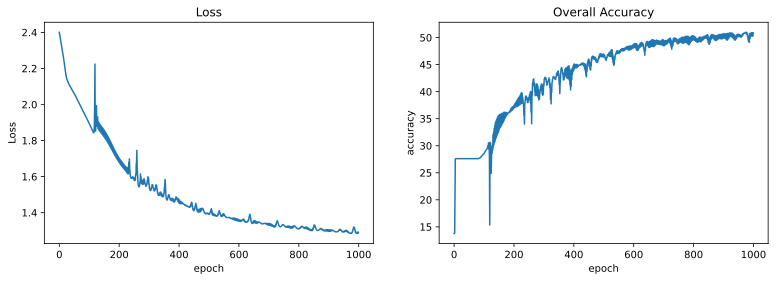

In [11]:
# Report Metrics
print('Final Model Accuracy: {0:.3f}'.format(final_accuracy))
print('Final Model Loss: {0:.3f}'.format(final_loss))

fig,ax = plt.subplots(1,2,figsize=(13,4))

# Loss
ax[0].plot(result['loss'])
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Loss')

# Overall Accuracy
ax[1].plot(result['accuracy'])
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Overall Accuracy')
plt.show()



In [12]:
# df_res = pd.DataFrame()

# for epoch_i in range(n_epochs):
#     matches = result['matches'][epoch_i]
#     matches_per_class = torch.stack([outputs.cpu(), matches], axis=1).numpy()
#     matches_per_class_df = pd.DataFrame(matches_per_class, columns=['label', 'match'])
#     matches_per_class_df.agg('label').sum()
#     df_analysis = matches_per_class_df.groupby(['label'], as_index=False).agg(['sum', 'count'])
#     df_analysis.columns = list(map('_'.join, df_analysis.columns.values))
#     df_analysis['accuracy'] = round(df_analysis['match_sum']/df_analysis['match_count'], 3)
#     df_analysis['epoch'] = epoch_i
#     df_res = df_res.append(df_analysis)

In [13]:
# df_res = df_res.reset_index()

In [14]:
# fig, ax = plt.subplots(11)

# for label in df_res['label'].unique():
#     df_label = df_res[df_res['label']==label]
#     y = ax[int(label)].plot(df_label['epoch'], df_label['accuracy'])
#     ax[int(label)].set_ylabel('accuracy')
#     ax[int(label)].set_xlabel('epoch')
#     ax[int(label)].set_title('Per Class Accuracy')
#     y.legend(1)

# plt.show()